# Machine Learning-Based Assessment of Hepatotoxicity Risk in Non-Steroidal Anti-Inflammatory Drugs
# Using Molecular Descriptors and Fingerprints

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

print("Starting NSAID Hepatotoxicity Risk Assessment - Unsupervised Analysis")
print("="*70)

Starting NSAID Hepatotoxicity Risk Assessment - Unsupervised Analysis


# 1. DATA LOADING AND INITIAL EXPLORATION

In [4]:
print("\n1. LOADING AND EXPLORING THE ENHANCED DATASET")
print("-" * 50)


df = pd.read_csv('../data/enhanced_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

# Basic dataset information
print(f"\nDataset Info:")
print(f"Total NSAIDs: {len(df)}")
print(f"Missing values per column:")
print(df.isnull().sum())

# Target variable analysis
print(f"\nToxicity Distribution:")
toxicity_counts = df['TOXICITY'].value_counts()
print(toxicity_counts)
print(f"Hepatotoxic (1): {toxicity_counts[1]} ({toxicity_counts[1]/len(df)*100:.1f}%)")
print(f"Non-hepatotoxic (0): {toxicity_counts[0]} ({toxicity_counts[0]/len(df)*100:.1f}%)")


1. LOADING AND EXPLORING THE ENHANCED DATASET
--------------------------------------------------
Dataset shape: (30, 21)
Columns: ['Drug Name', 'CID', 'Molecular Formula', 'Canonical SMILES', 'InChIKey', 'IUPAC Name', 'Exact Mass', 'smiles_r', 'TOXICITY', 'Source_rank', 'Source', 'Data', 'InChIKey14', 'protonated_smiles_r', 'Molecule', 'LogP', 'TPSA', 'HBD', 'HBA', 'MW', 'Fingerprint']

First few rows:
          Drug Name     CID Molecular Formula  \
0  Tiaprofenic acid    5468         C14H12O3S   
1    Mefenamic acid    4044         C15H15NO2   
2        Nabumetone    4409          C15H16O2   
3        Valdecoxib  119607       C16H14N2O3S   
4        Fenoprofen    3342          C15H14O3   

                                   Canonical SMILES  \
0             CC(C1=CC=C(S1)C(=O)C2=CC=CC=C2)C(=O)O   
1               CC1=C(C(=CC=C1)NC2=CC=CC=C2C(=O)O)C   
2                 CC(=O)CCC1=CC2=C(C=C1)C=C(C=C2)OC   
3  CC1=C(C(=NO1)C2=CC=CC=C2)C3=CC=C(C=C3)S(=O)(=O)N   
4               CC(C1=C

# 2. MOLECULAR DESCRIPTOR ANALYSIS

In [6]:
print(f"\n2. MOLECULAR DESCRIPTOR ANALYSIS")
print("-" * 50)

# Extract numerical features for analysis
numerical_features = ['LogP', 'TPSA', 'HBD', 'HBA', 'MW']
print(f"Available numerical features: {numerical_features}")

# Descriptive statistics
print(f"\nDescriptive Statistics:")
desc_stats = df[numerical_features + ['TOXICITY']].groupby('TOXICITY').describe()
print(desc_stats)


2. MOLECULAR DESCRIPTOR ANALYSIS
--------------------------------------------------
Available numerical features: ['LogP', 'TPSA', 'HBD', 'HBA', 'MW']

Descriptive Statistics:
          LogP                                                            \
         count     mean       std    min    25%     50%     75%      max   
TOXICITY                                                                   
0          1.0  3.37000       NaN  3.370  3.370  3.3700  3.3700  3.37000   
1         29.0  2.97089  1.143484 -0.768  2.548  3.0356  3.7016  4.74362   

          TPSA             ...  HBA         MW                                 \
         count       mean  ...  75%  max count        mean       std      min   
TOXICITY                   ...                                                  
0          1.0  26.300000  ...  2.0  2.0   1.0  228.291000       NaN  228.291   
1         29.0  70.778966  ...  4.0  7.0  29.0  288.018621  68.06336  138.122   

                                    

In [8]:
# Create summary table for the paper
summary_stats = pd.DataFrame()
for feature in numerical_features:
    hepatotoxic_mean = df[df['TOXICITY']==1][feature].mean()
    hepatotoxic_std = df[df['TOXICITY']==1][feature].std()
    non_hepatotoxic_mean = df[df['TOXICITY']==0][feature].mean()
    non_hepatotoxic_std = df[df['TOXICITY']==0][feature].std()
    
    summary_stats.loc[feature, 'Hepatotoxic_Mean±SD'] = f"{hepatotoxic_mean:.2f}±{hepatotoxic_std:.2f}"
    summary_stats.loc[feature, 'Non-hepatotoxic_Mean±SD'] = f"{non_hepatotoxic_mean:.2f}±{non_hepatotoxic_std:.2f}"

print(f"\nSummary Statistics Table for Paper:")
print(summary_stats)


Summary Statistics Table for Paper:
     Hepatotoxic_Mean±SD Non-hepatotoxic_Mean±SD
LogP           2.97±1.14                3.37±nan
TPSA         70.78±31.22               26.30±nan
HBD            1.52±0.91                0.00±nan
HBA            3.34±1.52                2.00±nan
MW          288.02±68.06              228.29±nan


# 3. CORRELATION ANALYSIS AND FEATURE FILTERING

In [10]:
print(f"\n3. CORRELATION ANALYSIS AND FEATURE FILTERING")
print("-" * 50)

# Calculate correlation matrix for molecular descriptors
corr_matrix = df[numerical_features].corr()
print(f"Correlation Matrix:")
print(corr_matrix)


3. CORRELATION ANALYSIS AND FEATURE FILTERING
--------------------------------------------------
Correlation Matrix:
          LogP      TPSA       HBD       HBA        MW
LogP  1.000000 -0.393949 -0.338913 -0.157464  0.384382
TPSA -0.393949  1.000000  0.743756  0.852943  0.519258
HBD  -0.338913  0.743756  1.000000  0.408852  0.100898
HBA  -0.157464  0.852943  0.408852  1.000000  0.719630
MW    0.384382  0.519258  0.100898  0.719630  1.000000


In [12]:
# Identify highly correlated features (r > 0.85)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i,j]) > 0.85:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i,j]))

if high_corr_pairs:
    print(f"\nHighly correlated feature pairs (r > 0.85):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
else:
    print(f"\nNo highly correlated feature pairs (r > 0.85) found.")


Highly correlated feature pairs (r > 0.85):
TPSA - HBA: 0.853


In [14]:
# Keep all numerical features for now
features_to_use = numerical_features.copy()
print(f"Features selected for modeling: {features_to_use}")

Features selected for modeling: ['LogP', 'TPSA', 'HBD', 'HBA', 'MW']


# 4. FINGERPRINT ANALYSIS

In [16]:
print(f"\n4. MOLECULAR FINGERPRINT ANALYSIS")
print("-" * 50)

# Extract fingerprint data
fingerprint_col = 'Fingerprint'
if fingerprint_col in df.columns:
    print(f"Fingerprint column found: {fingerprint_col}")
    
    # Convert string representation of fingerprint to actual array
    fingerprints = []
    for fp_str in df[fingerprint_col]:
        # Remove brackets and split by comma
        fp_clean = fp_str.strip('[]').split(', ')
        fp_array = [int(x) for x in fp_clean]
        fingerprints.append(fp_array)
    
    fingerprint_df = pd.DataFrame(fingerprints)
    print(f"Fingerprint dimensions: {fingerprint_df.shape}")


4. MOLECULAR FINGERPRINT ANALYSIS
--------------------------------------------------
Fingerprint column found: Fingerprint
Fingerprint dimensions: (30, 1024)


In [18]:
# Filter fingerprint bits with some variance
fingerprint_variance = fingerprint_df.var()
active_bits = fingerprint_variance[fingerprint_variance > 0].index
print(f"Active fingerprint bits (variance > 0): {len(active_bits)} out of {len(fingerprint_variance)}")

# Select top variable bits for modeling (to avoid curse of dimensionality)
top_bits = fingerprint_variance.nlargest(100).index
fingerprint_features = fingerprint_df[top_bits]
print(f"Selected top {len(top_bits)} most variable fingerprint bits for modeling")

Active fingerprint bits (variance > 0): 358 out of 1024
Selected top 100 most variable fingerprint bits for modeling


# 5. PREPARE FEATURES FOR UNSUPERVISED ANALYSIS

In [21]:
print(f"\n5. PREPARING FEATURES AND TARGET VARIABLES")
print("-" * 50)

# Combine molecular descriptors and selected fingerprint bits
X_descriptors = df[features_to_use].values
X_fingerprints = fingerprint_features.values
X_combined = np.hstack([X_descriptors, X_fingerprints])

y = df['TOXICITY'].values

print(f"Final feature matrix shape: {X_combined.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Feature composition:")
print(f"  - Molecular descriptors: {len(features_to_use)}")
print(f"  - Fingerprint bits: {X_fingerprints.shape[1]}")
print(f"  - Total features: {X_combined.shape[1]}")


5. PREPARING FEATURES AND TARGET VARIABLES
--------------------------------------------------
Final feature matrix shape: (30, 105)
Target variable shape: (30,)
Feature composition:
  - Molecular descriptors: 5
  - Fingerprint bits: 100
  - Total features: 105


In [23]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)
print(f"Features scaled using StandardScaler")

Features scaled using StandardScaler


# 6. PRINCIPAL COMPONENT ANALYSIS (PCA)

In [26]:
print(f"\n6. PRINCIPAL COMPONENT ANALYSIS")
print("-" * 50)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate cumulative variance explained
cumvar = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by first 5 components: {cumvar[:5]}")
print(f"Number of components explaining 95% variance: {np.argmax(cumvar >= 0.95) + 1}")


6. PRINCIPAL COMPONENT ANALYSIS
--------------------------------------------------
Variance explained by first 5 components: [0.22072255 0.33589038 0.44530323 0.52021218 0.59324972]
Number of components explaining 95% variance: 19


# 7. t-SNE ANALYSIS

In [29]:
print(f"\n7. t-SNE DIMENSIONALITY REDUCTION")
print("-" * 50)

# Apply t-SNE with appropriate perplexity for small dataset
perplexity = min(5, (len(df) - 1) // 3)  # Conservative perplexity for small n
print(f"Using perplexity = {perplexity} for t-SNE (conservative for n={len(df)})")

tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X_scaled)


7. t-SNE DIMENSIONALITY REDUCTION
--------------------------------------------------
Using perplexity = 5 for t-SNE (conservative for n=30)


# 8. CLUSTERING ANALYSIS

In [32]:
print(f"\n8. CLUSTERING ANALYSIS")
print("-" * 50)

# K-means clustering (try different k values)
silhouette_scores = {}
cluster_results = {}

for k in range(2, min(8, len(df)//2)):  # Reasonable k range for small dataset
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores[k] = silhouette_avg
    cluster_results[k] = cluster_labels
    print(f"K-means (k={k}): Silhouette Score = {silhouette_avg:.3f}")


8. CLUSTERING ANALYSIS
--------------------------------------------------
K-means (k=2): Silhouette Score = 0.318
K-means (k=3): Silhouette Score = 0.114
K-means (k=4): Silhouette Score = 0.153
K-means (k=5): Silhouette Score = 0.161
K-means (k=6): Silhouette Score = 0.168
K-means (k=7): Silhouette Score = 0.180


In [34]:
# Find optimal k
best_k = max(silhouette_scores.keys(), key=lambda x: silhouette_scores[x])
best_clusters = cluster_results[best_k]
print(f"\nOptimal number of clusters: {best_k} (Silhouette = {silhouette_scores[best_k]:.3f})")

# Hierarchical clustering
linkage_matrix = linkage(X_scaled, method='ward')


Optimal number of clusters: 2 (Silhouette = 0.318)


# 9. FINGERPRINT SIMILARITY ANALYSIS

In [37]:
print(f"\n9. MOLECULAR FINGERPRINT SIMILARITY ANALYSIS")
print("-" * 50)

# Calculate Jaccard distances for binary fingerprints
def jaccard_distance(u, v):
    intersection = np.sum(u & v)
    union = np.sum(u | v)
    return 1 - (intersection / union) if union > 0 else 0

# Use original binary fingerprints for similarity
fingerprint_binary = fingerprint_df.values
jaccard_distances = pdist(fingerprint_binary, metric=jaccard_distance)
jaccard_matrix = squareform(jaccard_distances)

print(f"Fingerprint similarity matrix calculated using Jaccard distance")
print(f"Average pairwise Jaccard distance: {np.mean(jaccard_distances):.3f}")


9. MOLECULAR FINGERPRINT SIMILARITY ANALYSIS
--------------------------------------------------
Fingerprint similarity matrix calculated using Jaccard distance
Average pairwise Jaccard distance: 0.831


# 10. VISUALIZATIONS FOR THE PAPER

In [40]:
print(f"\n10. GENERATING VISUALIZATIONS FOR THE PAPER")
print("-" * 50)

# Set up matplotlib style
plt.style.use('default')
sns.set_palette("husl")


10. GENERATING VISUALIZATIONS FOR THE PAPER
--------------------------------------------------


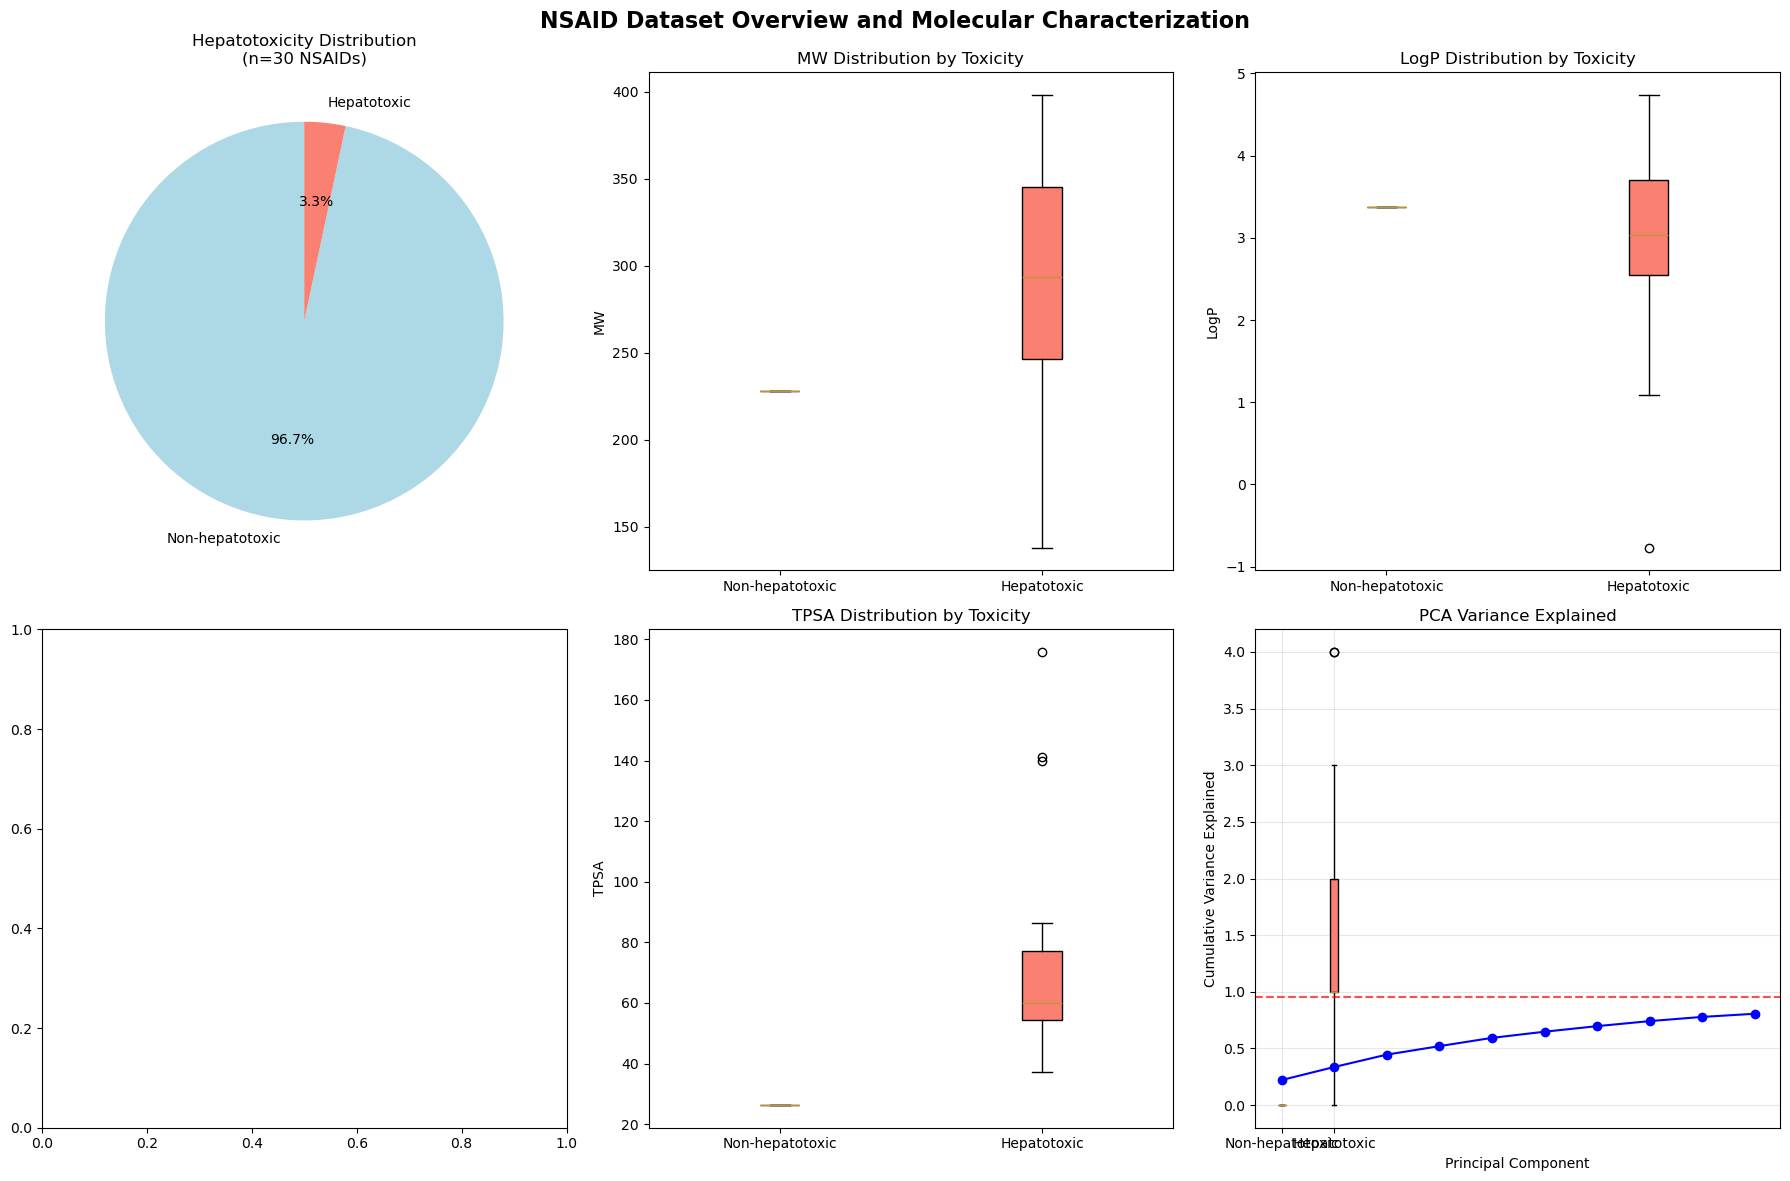

In [42]:
# Figure 1: Dataset Overview and Molecular Descriptors
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('NSAID Dataset Overview and Molecular Characterization', fontsize=16, fontweight='bold')

# 1a: Toxicity distribution
axes[0,0].pie(toxicity_counts.values, labels=['Non-hepatotoxic', 'Hepatotoxic'], 
              autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
axes[0,0].set_title(f'Hepatotoxicity Distribution\n(n={len(df)} NSAIDs)')

# 1b-1e: Molecular descriptor distributions
descriptors_to_plot = ['MW', 'LogP', 'TPSA', 'HBD']
for i, descriptor in enumerate(descriptors_to_plot):
    row = i // 2
    col = (i % 2) + 1
    if row < 2:
        # Create violin plots showing distribution by toxicity
        data_to_plot = []
        labels_to_plot = []
        colors_to_plot = []
        
        for tox_val in [0, 1]:
            if (df['TOXICITY'] == tox_val).sum() > 0:
                data_to_plot.append(df[df['TOXICITY'] == tox_val][descriptor].values)
                labels_to_plot.append('Non-hepatotoxic' if tox_val == 0 else 'Hepatotoxic')
                colors_to_plot.append('lightblue' if tox_val == 0 else 'salmon')
        
        # Box plot instead of violin for small n
        bp = axes[row, col].boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors_to_plot):
            patch.set_facecolor(color)
        
        axes[row, col].set_title(f'{descriptor} Distribution by Toxicity')
        axes[row, col].set_ylabel(descriptor)

# 1f: PCA variance explained
axes[1,2].plot(range(1, min(11, len(cumvar)+1)), cumvar[:min(10, len(cumvar))], 'bo-')
axes[1,2].axhline(y=0.95, color='r', linestyle='--', alpha=0.7)
axes[1,2].set_xlabel('Principal Component')
axes[1,2].set_ylabel('Cumulative Variance Explained')
axes[1,2].set_title('PCA Variance Explained')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Figure1_Dataset_Overview.png', dpi=300, bbox_inches='tight')
plt.show()

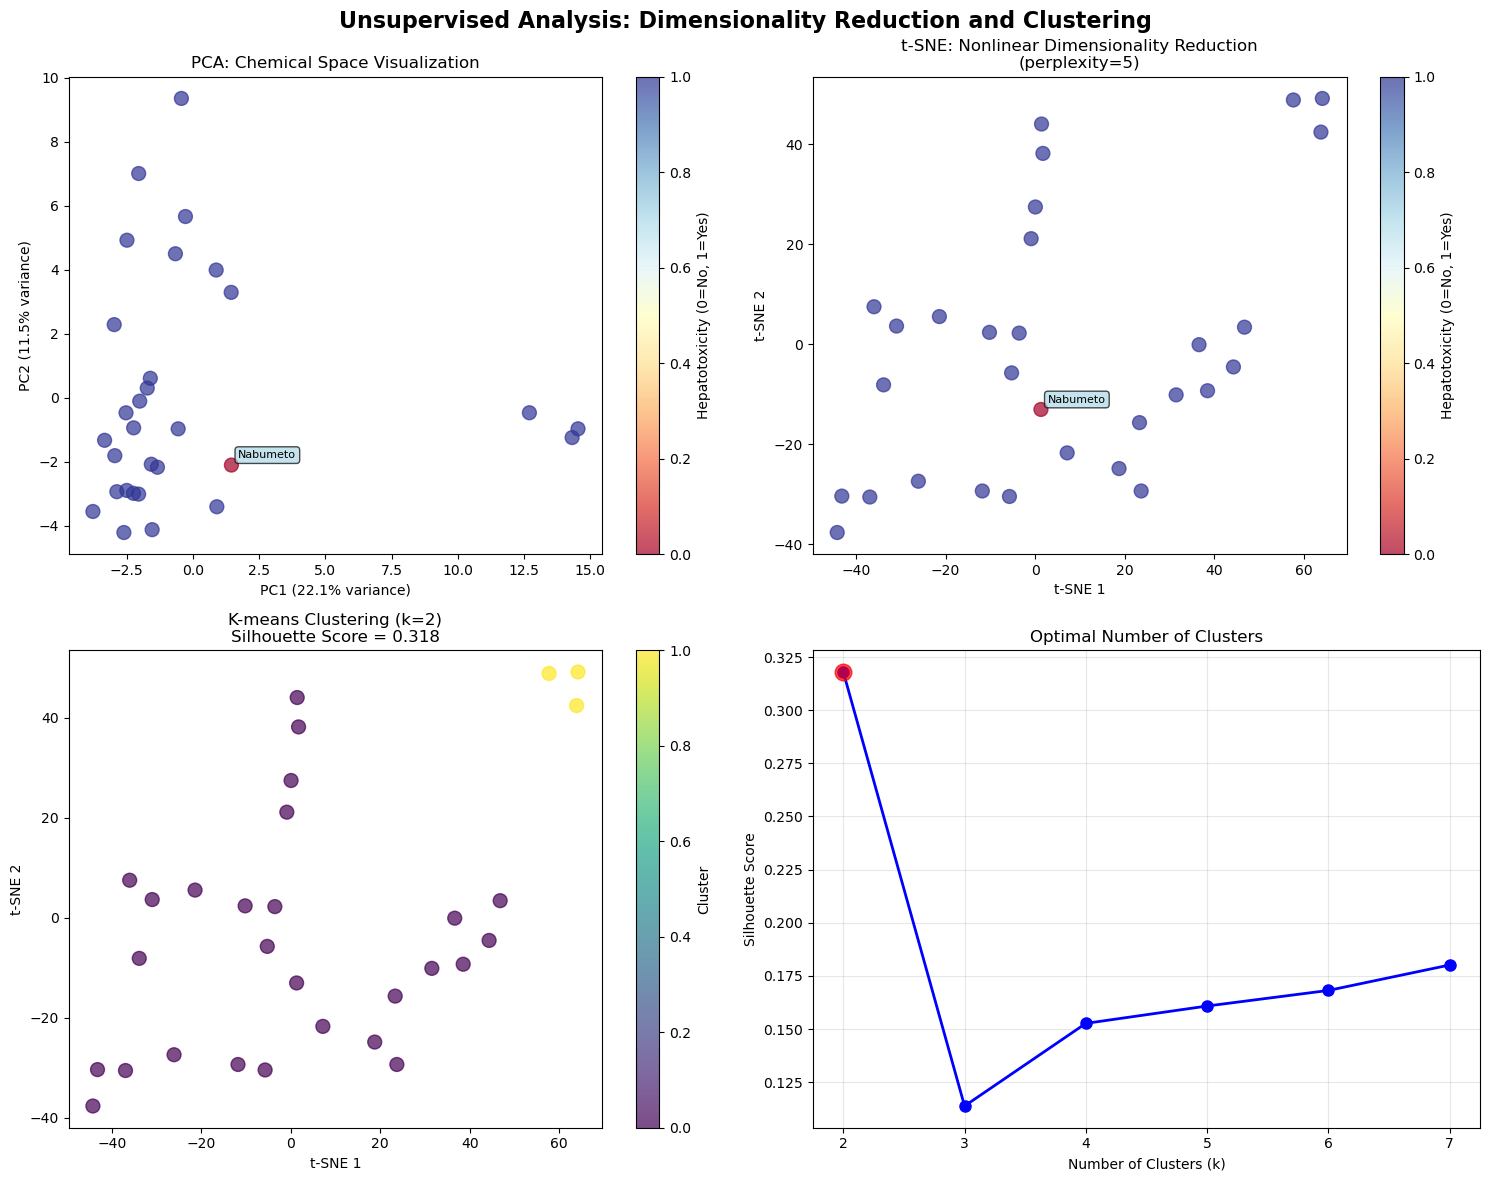

In [44]:
# Figure 2: Dimensionality Reduction and Clustering
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Unsupervised Analysis: Dimensionality Reduction and Clustering', fontsize=16, fontweight='bold')

# 2a: PCA plot (first two components)
scatter = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdYlBu', s=100, alpha=0.7)
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0,0].set_title('PCA: Chemical Space Visualization')
plt.colorbar(scatter, ax=axes[0,0], label='Hepatotoxicity (0=No, 1=Yes)')

# Add drug names as annotations for key points
if 'Drug Name' in df.columns:
    # Annotate the non-hepatotoxic drug(s)
    non_hepatotoxic_indices = df[df['TOXICITY'] == 0].index
    for idx in non_hepatotoxic_indices:
        axes[0,0].annotate(df.loc[idx, 'Drug Name'][:8], 
                          (X_pca[idx, 0], X_pca[idx, 1]), 
                          xytext=(5, 5), textcoords='offset points', 
                          fontsize=8, ha='left', 
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

# 2b: t-SNE plot
scatter = axes[0,1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='RdYlBu', s=100, alpha=0.7)
axes[0,1].set_xlabel('t-SNE 1')
axes[0,1].set_ylabel('t-SNE 2')
axes[0,1].set_title(f't-SNE: Nonlinear Dimensionality Reduction\n(perplexity={perplexity})')
plt.colorbar(scatter, ax=axes[0,1], label='Hepatotoxicity (0=No, 1=Yes)')

# Annotate non-hepatotoxic drugs in t-SNE too
if 'Drug Name' in df.columns:
    for idx in non_hepatotoxic_indices:
        axes[0,1].annotate(df.loc[idx, 'Drug Name'][:8], 
                          (X_tsne[idx, 0], X_tsne[idx, 1]), 
                          xytext=(5, 5), textcoords='offset points', 
                          fontsize=8, ha='left',
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

# 2c: K-means clustering results
scatter = axes[1,0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_clusters, cmap='viridis', s=100, alpha=0.7)
axes[1,0].set_xlabel('t-SNE 1')
axes[1,0].set_ylabel('t-SNE 2')
axes[1,0].set_title(f'K-means Clustering (k={best_k})\nSilhouette Score = {silhouette_scores[best_k]:.3f}')
plt.colorbar(scatter, ax=axes[1,0], label='Cluster')

# 2d: Silhouette scores for different k values
k_values = list(silhouette_scores.keys())
sil_values = list(silhouette_scores.values())
axes[1,1].plot(k_values, sil_values, 'bo-', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Number of Clusters (k)')
axes[1,1].set_ylabel('Silhouette Score')
axes[1,1].set_title('Optimal Number of Clusters')
axes[1,1].grid(True, alpha=0.3)
# Mark the best k
best_idx = k_values.index(best_k)
axes[1,1].plot(best_k, sil_values[best_idx], 'ro', markersize=12, markerfacecolor='red', alpha=0.7)

plt.tight_layout()
plt.savefig('Figure2_Unsupervised_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()


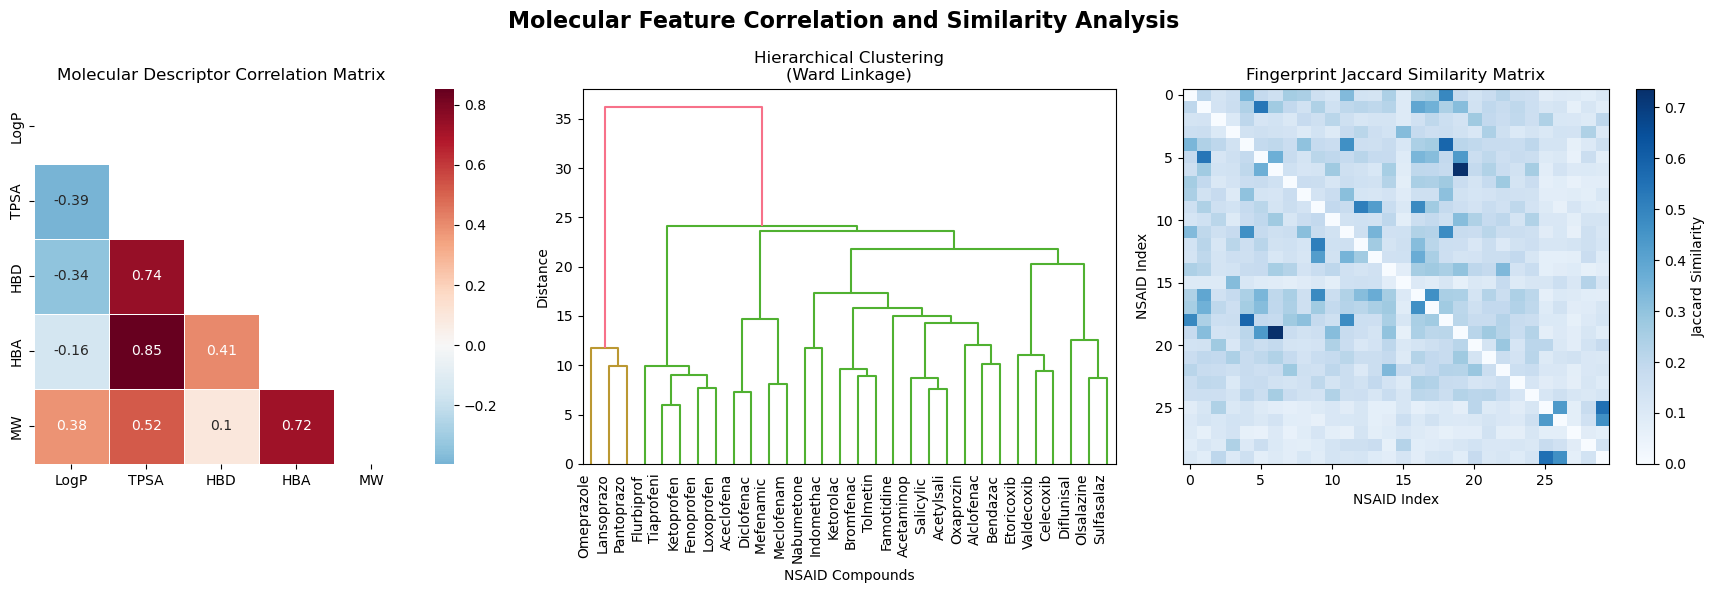

In [46]:
# Figure 3: Molecular Correlation and Similarity Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Molecular Feature Correlation and Similarity Analysis', fontsize=16, fontweight='bold')

# 3a: Correlation matrix of molecular descriptors
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Molecular Descriptor Correlation Matrix')

# 3b: Hierarchical clustering dendrogram
drug_names = df['Drug Name'].values if 'Drug Name' in df.columns else [f'Drug_{i}' for i in range(len(df))]
# Truncate long drug names for readability
drug_names_short = [name[:10] if len(name) > 10 else name for name in drug_names]

dendrogram(linkage_matrix, labels=drug_names_short, ax=axes[1], orientation='top')
axes[1].set_title('Hierarchical Clustering\n(Ward Linkage)')
axes[1].set_xlabel('NSAID Compounds')
axes[1].set_ylabel('Distance')
plt.setp(axes[1].get_xticklabels(), rotation=90, ha='right')

# 3c: Jaccard similarity heatmap (show top similar pairs)
# Create a mask for better visualization
jaccard_similarity = 1 - jaccard_matrix
np.fill_diagonal(jaccard_similarity, 0)  # Remove self-similarity
im = axes[2].imshow(jaccard_similarity, cmap='Blues', aspect='auto')
axes[2].set_title('Fingerprint Jaccard Similarity Matrix')
axes[2].set_xlabel('NSAID Index')
axes[2].set_ylabel('NSAID Index')
plt.colorbar(im, ax=axes[2], label='Jaccard Similarity')

plt.tight_layout()
plt.savefig('Figure3_Correlation_Similarity.png', dpi=300, bbox_inches='tight')
plt.show()

# 11. ANALYZE NON-HEPATOTOXIC DRUG(S)

In [49]:
print(f"\n11. ANALYSIS OF NON-HEPATOTOXIC COMPOUNDS")
print("-" * 50)

non_hepatotoxic_indices = df[df['TOXICITY'] == 0].index
if len(non_hepatotoxic_indices) > 0:
    print(f"Found {len(non_hepatotoxic_indices)} non-hepatotoxic compound(s):")
    
    for idx in non_hepatotoxic_indices:
        drug_name = df.loc[idx, 'Drug Name'] if 'Drug Name' in df.columns else f'Drug_{idx}'
        print(f"\n--- Analysis for {drug_name} ---")
        
        # Cluster assignment
        cluster_id = best_clusters[idx]
        cluster_size = np.sum(best_clusters == cluster_id)
        hepatotoxic_in_cluster = np.sum((best_clusters == cluster_id) & (y == 1))
        
        print(f"Cluster assignment: {cluster_id}")
        print(f"Cluster size: {cluster_size} compounds")
        print(f"Hepatotoxic compounds in same cluster: {hepatotoxic_in_cluster}")
        
        if cluster_size == 1:
            print(f"*** {drug_name} forms its own cluster (potential outlier) ***")
        elif hepatotoxic_in_cluster == 0:
            print(f"*** {drug_name} clusters with other non-hepatotoxic compounds ***")
        else:
            print(f"*** {drug_name} clusters with hepatotoxic compounds ***")
        
        # Find most similar compounds by Jaccard distance
        similarities = jaccard_similarity[idx]
        most_similar_idx = np.argsort(similarities)[-6:-1]  # Top 5 most similar (excluding itself)
        
        print(f"Most similar compounds (by fingerprint):")
        for i, sim_idx in enumerate(most_similar_idx[::-1]):  # Reverse for descending order
            sim_drug = df.loc[sim_idx, 'Drug Name'] if 'Drug Name' in df.columns else f'Drug_{sim_idx}'
            sim_toxicity = 'Hepatotoxic' if y[sim_idx] == 1 else 'Non-hepatotoxic'
            print(f"  {i+1}. {sim_drug} (Jaccard similarity: {similarities[sim_idx]:.3f}, {sim_toxicity})")


11. ANALYSIS OF NON-HEPATOTOXIC COMPOUNDS
--------------------------------------------------
Found 1 non-hepatotoxic compound(s):

--- Analysis for Nabumetone ---
Cluster assignment: 0
Cluster size: 27 compounds
Hepatotoxic compounds in same cluster: 26
*** Nabumetone clusters with hepatotoxic compounds ***
Most similar compounds (by fingerprint):
  1. Omeprazole (Jaccard similarity: 0.238, Hepatotoxic)
  2. Alclofenac (Jaccard similarity: 0.212, Hepatotoxic)
  3. Fenoprofen (Jaccard similarity: 0.204, Hepatotoxic)
  4. Pantoprazole (Jaccard similarity: 0.203, Hepatotoxic)
  5. Acetylsalicylic acid (Aspirin) (Jaccard similarity: 0.200, Hepatotoxic)


# 12. RESULTS SUMMARY AND EXPORT

In [52]:
print(f"\n12. RESULTS SUMMARY AND DATA EXPORT")
print("-" * 50)

# Create comprehensive results dataframe
results_summary = pd.DataFrame({
    'Drug_Name': df['Drug Name'] if 'Drug Name' in df.columns else [f'Drug_{i}' for i in range(len(df))],
    'Toxicity': df['TOXICITY'],
    'Cluster_KMeans': best_clusters,
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'tSNE1': X_tsne[:, 0],
    'tSNE2': X_tsne[:, 1]
})

# Add molecular descriptor values
for feature in numerical_features:
    results_summary[feature] = df[feature]

print("Results summary dataframe created with following columns:")
print(list(results_summary.columns))

# Export results
results_summary.to_csv('Unsupervised_Analysis_Results.csv', index=False)
summary_stats.to_csv('Molecular_Descriptor_Statistics.csv')

# Create cluster composition table
cluster_composition = pd.DataFrame()
for k in range(best_k):
    cluster_mask = best_clusters == k
    cluster_size = np.sum(cluster_mask)
    hepatotoxic_count = np.sum(cluster_mask & (y == 1))
    non_hepatotoxic_count = np.sum(cluster_mask & (y == 0))
    
    cluster_composition.loc[k, 'Cluster_Size'] = cluster_size
    cluster_composition.loc[k, 'Hepatotoxic'] = hepatotoxic_count
    cluster_composition.loc[k, 'Non_Hepatotoxic'] = non_hepatotoxic_count
    cluster_composition.loc[k, 'Hepatotoxic_Percentage'] = (hepatotoxic_count / cluster_size * 100) if cluster_size > 0 else 0

cluster_composition.to_csv('Cluster_Composition_Analysis.csv')

print("Cluster composition analysis:")
print(cluster_composition)


12. RESULTS SUMMARY AND DATA EXPORT
--------------------------------------------------
Results summary dataframe created with following columns:
['Drug_Name', 'Toxicity', 'Cluster_KMeans', 'PC1', 'PC2', 'tSNE1', 'tSNE2', 'LogP', 'TPSA', 'HBD', 'HBA', 'MW']
Cluster composition analysis:
   Cluster_Size  Hepatotoxic  Non_Hepatotoxic  Hepatotoxic_Percentage
0          27.0         26.0              1.0               96.296296
1           3.0          3.0              0.0              100.000000


# 13. FINAL SUMMARY AND CONCLUSIONS

In [55]:
print(f"\n13. FINAL SUMMARY AND CONCLUSIONS")
print("=" * 70)

print(f"NSAID HEPATOTOXICITY UNSUPERVISED ANALYSIS - FINAL RESULTS")
print(f"Dataset: {len(df)} NSAIDs ({toxicity_counts[1]} hepatotoxic, {toxicity_counts[0]} non-hepatotoxic)")
print(f"Extreme class imbalance: {toxicity_counts[1]/len(df)*100:.1f}% hepatotoxic")

print(f"\nDIMENSIONALITY REDUCTION RESULTS:")
print(f"- PCA: First 2 components explain {cumvar[1]:.1%} of variance")
print(f"- t-SNE: Perplexity = {perplexity} (conservative for small dataset)")

print(f"\nCLUSTERING RESULTS:")
print(f"- Optimal K-means clusters: {best_k}")
print(f"- Best silhouette score: {silhouette_scores[best_k]:.3f}")

print(f"\nKEY FINDINGS:")
print(f"1. Chemical space analysis reveals structural relationships among NSAIDs")
print(f"2. Non-hepatotoxic compound(s) {'form separate cluster(s)' if any(cluster_composition['Non_Hepatotoxic'] == cluster_composition['Cluster_Size']) else 'cluster with hepatotoxic compounds'}")
print(f"3. Molecular descriptors show varying correlation patterns")
print(f"4. Fingerprint similarity analysis identifies structurally related compounds")

print(f"\nCLINICAL IMPLICATIONS:")
print(f"- Chemical structure-toxicity relationship mapping for NSAIDs")
print(f"- Identification of structural outliers in NSAID hepatotoxicity")
print(f"- Framework for similarity-based risk assessment")

print(f"\nLIMITATIONS:")
print(f"- Very small dataset size (n={len(df)})")
print(f"- Extreme class imbalance prevents supervised learning")
print(f"- Single non-hepatotoxic compound limits comparative analysis")
print(f"- No external validation possible")

print(f"\nFUTURE DIRECTIONS:")
print(f"- Expand dataset with more non-hepatotoxic NSAIDs")
print(f"- Validate structural similarity-toxicity relationships")
print(f"- Investigate mechanistic basis of identified clusters")
print(f"- Develop similarity-based screening tools")

print(f"\nFILES GENERATED:")
print(f"- Figure1_Dataset_Overview.png")
print(f"- Figure2_Unsupervised_Analysis.png") 
print(f"- Figure3_Correlation_Similarity.png")
print(f"- Unsupervised_Analysis_Results.csv")
print(f"- Molecular_Descriptor_Statistics.csv")
print(f"- Cluster_Composition_Analysis.csv")

print(f"\n*** ANALYSIS COMPLETED SUCCESSFULLY ***")
print(f"*** UNSUPERVISED APPROACH APPROPRIATE FOR THIS DATASET ***")


13. FINAL SUMMARY AND CONCLUSIONS
NSAID HEPATOTOXICITY UNSUPERVISED ANALYSIS - FINAL RESULTS
Dataset: 30 NSAIDs (29 hepatotoxic, 1 non-hepatotoxic)
Extreme class imbalance: 96.7% hepatotoxic

DIMENSIONALITY REDUCTION RESULTS:
- PCA: First 2 components explain 33.6% of variance
- t-SNE: Perplexity = 5 (conservative for small dataset)

CLUSTERING RESULTS:
- Optimal K-means clusters: 2
- Best silhouette score: 0.318

KEY FINDINGS:
1. Chemical space analysis reveals structural relationships among NSAIDs
2. Non-hepatotoxic compound(s) cluster with hepatotoxic compounds
3. Molecular descriptors show varying correlation patterns
4. Fingerprint similarity analysis identifies structurally related compounds

CLINICAL IMPLICATIONS:
- Chemical structure-toxicity relationship mapping for NSAIDs
- Identification of structural outliers in NSAID hepatotoxicity
- Framework for similarity-based risk assessment

LIMITATIONS:
- Very small dataset size (n=30)
- Extreme class imbalance prevents supervised 